<a href="https://colab.research.google.com/github/theIcebaer/colab_notebooks/blob/main/setup_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In diesem Notebook wird ein Startpunkt für weitere Experimente gesetzt. Die zu lernenden Daten bestehen aus dem MNIST datensatz der durch ein einziges zufällig generiertes Flussfeld (flow field) verzerrt wurde. Dieses setup ist vor allem dazu da die technische basis für komplexere Experimente zu verifizieren. Außerdem werden technische Parameter des Trainings (batch size, num workers, etc...) in Abhängigkeit der zur verfügung stehenden Plattform  (google colab) erkundet.

In [37]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [38]:
#  !pip install imgaug==0.2.5
!pip install git+https://github.com/VLL-HD/FrEIA.git@v0.2
!pip install voxelmorph


  Cloning https://github.com/VLL-HD/FrEIA.git (to revision v0.2) to /tmp/pip-req-build-bts9lemc
  Running command git clone -q https://github.com/VLL-HD/FrEIA.git /tmp/pip-req-build-bts9lemc
  Running command git checkout -q 033f6fd6eb4d2ddbc98f746a9ef5f8c619587abe


In [3]:
import torch
import torch.nn as nn

import torchvision
import torchvision.datasets as datasets
import torch.utils as utils

import FrEIA.framework as Ff
import FrEIA.modules as Fm

import numpy as np
import copy
import pdb

import matplotlib.pyplot as plt

%pdb off

Automatic pdb calling has been turned OFF


In [4]:
DEBUG = False

In [5]:
def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                        nn.Linear(512,  c_out))

def subnet_conv(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   3, padding=1), 
                         nn.ReLU(),
                        nn.Conv2d(256,  c_out, 3, padding=1))

def subnet_conv_1x1(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 1))

In [6]:
!ls /content/gdrive/MyDrive/code/data/data_generation

big_dummy_data	mnist_distortions_10_fields.dat  mnist_rnd_distortions_1.dat
dummy_data.dat	mnist_distortions_20_fields.dat  __pycache__
gen_data.py	mnist_distortions_2_fields.dat	 utils.py
mnist_data	mnist_distortions.dat


In [7]:
# mnist_dist = torch.load("/content/gdrive/MyDrive/gd_thesis/mnist_rnd_distortions_10.dat")

In [8]:
# mnist_dist.keys()
# original= mnist_dist['original_image']
# original.shape

In [9]:
n_epochs = 60
batch_size = 64

In [10]:

device = 'cpu'

# data_dict = torch.load("/content/gdrive/MyDrive/code/data/data_generation/big_dummy_data")
data_dict = torch.load("/content/gdrive/MyDrive/gd_thesis/mnist_rnd_distortions_10.dat")
# data_dict = torch.load("/content/gdrive/MyDrive/code/data/data_generation/mnist_rnd_distortions_1.dat")

for k in data_dict:
    print(k)

original
vfield
transformed
deformations
description


In [11]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader



print(data_dict['original'].shape, data_dict['transformed'].shape )

conditions = torch.cat([data_dict['original'], data_dict['transformed']], dim=1)
deformations = data_dict['deformations']
velocities = data_dict['vfield']

print(velocities.shape)

data_set = TensorDataset(velocities.float(), conditions.float())

train_set, val_set, test_set = torch.utils.data.random_split(data_set, [47712, 4096, 8192], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=batch_size)
print(len(val_set))

torch.Size([60000, 1, 28, 28]) torch.Size([60000, 1, 28, 28])
torch.Size([60000, 2, 28, 28])
4096


In [12]:
k = data_dict['original'].shape[0]
print(k)

60000


In [13]:
# matplotlib.use(ca)

def show_example_img(data_dict):
    n_cols = 3
    n_samples = 9
    
    np.random.seed(78)
    
    n = data_dict['original'].shape[0]
    idx = np.random.randint(0, n+1, size=n_samples)
    print(idx)
    
    
    fig = plt.figure(figsize=(30,20))
    for i in range(n_samples):
        m = data_dict["original"][idx[i]].type(torch.float)
        f = data_dict['transformed'][idx[i]].type(torch.float)
        d_field = data_dict['deformations'][idx[i]].type(torch.float)
        v_field = data_dict['vfield'][idx[i]].type(torch.float)
        # print(v_field)
        # v_field[0, :, :] = 0
        # v_field[1,:,: ] = 10
        # print(v_field)


        v, u = v_field[0, :, :], -v_field[1, :, :]
        d_u, d_v = d_field[0, :, :], d_field[1, :, :]
        x,y = np.meshgrid(np.linspace(0, 27, 28),np.linspace(0, 27, 28))


        fig = plt.figure(figsize=(10,10))
        plt.imshow(m[0])
        plt.savefig('/content/gdrive/MyDrive/gd_thesis/figures/example_m_0{}.png'.format(i))
        # fig.close()

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(1,1,1)
        ax.set_aspect('equal')
        plt.streamplot(x,y, u,v)  
        plt.savefig('/content/gdrive/MyDrive/gd_thesis/figures/example_vfield_0{}.png'.format(i))
        # fig.close()

        fig = plt.figure(figsize=(10,10))
        plt.imshow(f[0])
        plt.savefig('/content/gdrive/MyDrive/gd_thesis/figures/example_f_0{}.png'.format(i))
        # fig.close()
        

    #     # f_, d_ = apply_flow(np.expand_dims(m, 0),v_field=np.expand_dims(v_field, 0))

    #     ax1 = fig.add_subplot(n_samples, n_cols, i*n_cols+1)
    #     plt.imshow(m[0])
        
    #     ax2 = fig.add_subplot(n_samples, n_cols, i*n_cols+2)
    #     ax2.set_aspect('equal')
    #     plt.streamplot(x,y, u,v)               
        
    #     ax3 = fig.add_subplot(n_samples, n_cols, i*n_cols+3)
    #     plt.imshow(f[0] )

    

    # plt.savefig('/content/gdrive/MyDrive/gd_thesis/figures/example_m_01.png')

    # plt.show()
    plt.close()


# show_example_img(data_dict)

In [14]:
# uniques = np.unique(velocities, axis=0)
# uniques.shape

In [15]:
class CondNet(nn.Module):

    def __init__(self):
        super().__init__()

        class Flatten(nn.Module):
            def __init__(self, *args):
                super().__init__()
            def forward(self, x):
                return x.view(x.shape[0], -1)

        # self.Flatten = Flatten()
        # self.Linear = nn.Linear(512,512)

        self.resolution_levels = nn.ModuleList([
                                                nn.Sequential(nn.Conv2d(2, 64, 3, padding=1), nn.LeakyReLU(), nn.Conv2d(64, 64, 3, padding=1)),
                                                nn.Sequential(nn.LeakyReLU(), nn.Conv2d(64, 128, 3, padding=1), nn.LeakyReLU(), nn.Conv2d(128,128,3, padding=1, stride=2)),
                                                nn.Sequential(nn.LeakyReLU(),nn.Conv2d(128, 128, 3, padding=1, stride=2)),
                                                nn.Sequential(nn.LeakyReLU(), nn.AvgPool2d(3), Flatten(), nn.Linear(512, 512))
                                                ])
    def forward(self, c):
        outputs = [c]
        # print(c.shape)
        for i, m  in enumerate(self.resolution_levels):
            # print(i)
            # print(m.shape)
            outputs.append(m(outputs[-1]))
        #     print(outputs[-1].shape)  
        # outputs[-1] = nn.LeakyReLU()(outputs[-1])
        # print(outputs[-1].shape)
        # outputs[-1] = nn.AvgPool2d(3)(outputs[-1])
        # print(outputs[-1].shape)
        # outputs[-1] = self.Flatten(outputs[-1])
        # print(outputs[-1].shape)
        # outputs[-1] =  self.Linear(outputs[-1])
        return outputs[1:]

v, c = next(iter(train_loader))
# v = torch.randn(128, 2, 64, 64)
# c = torch.randn(128, 2, 64, 64)
net = CondNet()

c = net(c)
# print(c.shape)

# torch.Size([128, 64, 64, 64])
# torch.Size([128, 128, 32, 32])
# torch.Size([128, 128, 16, 16])
# torch.Size([128, 128, 16, 16])
# torch.Size([128, 128, 4, 4])
# torch.Size([128, 2048])

In [39]:
class Reg_mnist_cINN_Unet(nn.Module): 
    def __init__(self):
        super(Reg_mnist_cINN_Unet, self).__init__()
        self.cinn = self.build_inn()
        self.cond_net = CondNet()

    def build_inn(self):

        def sub_conv(ch_hidden, kernel):
            pad = kernel // 2
            return lambda ch_in, ch_out: nn.Sequential(
                                            nn.Conv2d(ch_in, ch_hidden, kernel, padding=pad),
                                            nn.ReLU(),
                                            nn.Conv2d(ch_hidden, ch_out, kernel, padding=pad))

        def sub_fc(ch_hidden):
            return lambda ch_in, ch_out: nn.Sequential(
                                            nn.Linear(ch_in, ch_hidden),
                                            nn.ReLU(),
                                            nn.Linear(ch_hidden, ch_out))

        nodes = [Ff.InputNode(2, 28, 28)]
        # outputs of the cond. net at different resolution levels
        conditions = [Ff.ConditionNode(64, 28, 28),
                      Ff.ConditionNode(128, 14, 14),
                      Ff.ConditionNode(128, 7, 7),
                      Ff.ConditionNode(512)]

        split_nodes = []

        subnet = sub_conv(32, 3)
        for k in range(2):
            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {'subnet_constructor':subnet, 'clamp':1.0},
                                 conditions=conditions[0]))

        nodes.append(Ff.Node(nodes[-1], Fm.HaarDownsampling, {'rebalance':0.5}))

        for k in range(4):
            subnet = sub_conv(64, 3 if k%2 else 1)

            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {'subnet_constructor':subnet, 'clamp':1.0},
                                 conditions=conditions[1]))
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom, {'seed':k}))

        #split off 6/8 ch
        nodes.append(Ff.Node(nodes[-1], Fm.Split1D,
                             {'split_size_or_sections':[2,6], 'dim':0}))
        split_nodes.append(Ff.Node(nodes[-1].out1, Fm.Flatten, {}))

        nodes.append(Ff.Node(nodes[-1], Fm.HaarDownsampling, {'rebalance':0.5}))

        for k in range(4):
            subnet = sub_conv(128, 3 if k%2 else 1)

            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {'subnet_constructor':subnet, 'clamp':0.6},
                                 conditions=conditions[2]))
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom, {'seed':k}))

        #split off 4/8 ch
        nodes.append(Ff.Node(nodes[-1], Fm.Split1D,
                             {'split_size_or_sections':[4,4], 'dim':0}))
        split_nodes.append(Ff.Node(nodes[-1].out1, Fm.Flatten, {}))
        nodes.append(Ff.Node(nodes[-1], Fm.Flatten, {}, name='flatten'))

        # fully_connected part
        subnet = sub_fc(512)
        for k in range(4):
            nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                 {'subnet_constructor':subnet, 'clamp':0.6},
                                 conditions=conditions[3]))
            nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom, {'seed':k}))

        # concat everything
        nodes.append(Ff.Node([s.out0 for s in split_nodes] + [nodes[-1].out0],
                             Fm.Concat1d, {'dim':0}))
        nodes.append(Ff.OutputNode(nodes[-1]))

        return Ff.ReversibleGraphNet(nodes + split_nodes + conditions, verbose=False)

    def forward(self, x, c, rev=False):
        c = self.cond_net(c)
        z = self.cinn(x, c, rev=rev)
        log_j = self.cinn.log_jacobian(run_forward=False)
        return z, log_j

    def reverse_sample(self, z, L):
        return self.cinn(z, c=self.cond_net(L), rev=True)

    def init(self):
        for p in self.cinn.parameters():
            if p.requires_grad:
                p.data = 0.01 * torch.randn_like(p)



In [16]:
# Testing the condition net on my input

from torchvision.models import mobilenet_v3_small
from torchvision.models import resnet18
from skimage.color import gray2rgb

# model = mobilenet_v3_small(pretrained=True)
model = resnet18(pretrained=True)
# print(model)

class Mynet(nn.Module):
    def __init__(self, model):
        super().__init__()

        self.upscale = nn.Conv2d(2, 3, 3, padding=1)

        self.features = nn.Sequential(*list(model.children())[:-2])
        # print(self.features)

    def forward(self, x):
        x = self.upscale(x)
        x = self.features(x)

        return x

    # def init_weights()




v, c = next(iter(train_loader))

# print(c.shape)

mynet = Mynet(model)
# c = np.random.randn(64,2, 22)



# mynet = CondNet()

cond = mynet(c)
print(cond.shape)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



torch.Size([64, 512, 1, 1])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [23]:
class Reg_mnist_cINN(nn.Module): 
    def __init__(self, model):
        super(Reg_mnist_cINN, self).__init__()
        self.flat_layer = torch.nn.Flatten(start_dim=1, end_dim=-1)
        self.cinn = self.build_inn()
        self.cond_net = Mynet(model)
        for param in self.cond_net.parameters():
            param.requires_grad = False

    def build_inn(self):

            def subnet(ch_in, ch_out):
                return nn.Sequential(nn.Linear(ch_in, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, ch_out))
            # def sub_conv(ch_hidden, kernel):
            #     pad = kernel//2
            #     return lambda ch_in, ch_out: nn.Sequential(
            #         nn.Conv2d(ch_in, ch_hidden, kernel, padding=pad)
            #         nn.ReLu(),
            #         nn.Conv2d(ch_hidden, ch_out, kernel, padding=pad)
            #     )

            # def sub_fc(ch_hidden):
            #     return lambda ch_in, ch_out: nn.Sequential(
            #         nn.Conv2d(ch_in, ch_hidden kernel)
            #         nn.ReLu(),
            #         nn.Conv2d(ch_hidden, ch_out)
            #     )



            # cond = Ff.ConditionNode(576, name='condition')
            cond = Ff.ConditionNode(512, name='condition')
            # conditions = [Ff.ConditionNode(28, 28, 28),
            #               Ff.ConditionNode(56, 14, 14),
            #               Ff.ConditionNode(112, 7, 7)
            #               Ff.ConditionNode(512)]
            # split_nodes = []




            nodes = [Ff.InputNode(2, 28, 28, name='flat')]

            nodes.append(Ff.Node(nodes[-1], Fm.Flatten, {}, name='flat'))

            for k in range(20):
                nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom , {'seed':k}, name="permute_{}".format(k)))
                nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                    {'subnet_constructor':subnet, 'clamp':1.0},
                                    conditions=cond,
                                    name="Coupling_Block_{}".format(k)))

            return Ff.ReversibleGraphNet(nodes + [cond, Ff.OutputNode(nodes[-1])], verbose=False)

    def forward(self, x, c, rev=False):
        c = self.cond_net(c)
        z = self.cinn(x, [self.flat_layer(c)], rev=rev)
        log_j = self.cinn.log_jacobian(run_forward=False)
        return z, log_j

    def reverse_sample(self, z, c):
        # x = self.cinn((x, [self.flat_layer(c)], rev=True))
        # return x
        pass
    def init(self):
        for p in cinn.parameters():
            if p.requires_grad:
                p.data = 0.01 * torch.randn_like(p)



In [40]:
device = torch.device("cuda")

cinn = Reg_mnist_cINN_Unet()
cinn.init()
cinn.to(device)
print("done")

done


In [41]:
augm_sigma = 0.08
ndim_total = 2* 28*28

cinn.train()

train_params = [p for p in cinn.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(train_params, lr=5e-4,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)

checkpoints = []

loss_log = {"nll": [],
            "val_nll": [],
            "epoch": [],
            "batch": []}

In [42]:



print("epoch \t batch \t nll \t aggregated nll \t validation nll")





for e in range(n_epochs):
    agg_nll = []
    for i, (im, cond) in enumerate(train_loader):

        im = im.to(device)
        cond = cond.to(device)

        out, log_j = cinn(im, c=cond)

        alt_nll = torch.mean(out**2 / 2) - torch.mean(log_j) / ndim_total

        nll = 0.5 * torch.sum(out**2, dim=1) - log_j
        nll = torch.mean(nll)/ndim_total

        alt_nll.backward()

        #print("{}\t{}\t{}".format(e, i, alt_nll.item()))

        torch.nn.utils.clip_grad_norm_(train_params, 100.)


        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()


        if i % 20 == 0:
            with torch.no_grad():
                val_x, val_c = next(iter(val_loader))
                val_x, val_c = val_x.to(device), val_c.to(device)
                    
                v_out, v_log_j = cinn(val_x, c=val_c)
                v_nll =  torch.mean(v_out**2) / 2 - torch.mean(v_log_j) / ndim_total
                loss_log['nll'].append(alt_nll.item())
                loss_log['val_nll'].append(v_nll.item())
                loss_log['epoch'].append(e)
                loss_log["batch"].append(i)
                print("{}\t{}\t{}\t{}\t{}".format(e, i, alt_nll.item(),nll.item(), v_nll.item()))


                
            
        #         a_nll = np.mean(agg_nll)
                # mean_v_nll = np.mean(agg_v_nll)
                # print("{}\t{}\t{}\t{}".format(e, i, alt_nll.item(), mean_v_nll.item()))
        #         agg_nll = []

        #         checkpoint = {
        #             "model": cinn,
        #             "state_dict": cinn.state_dict(),
        #             "opimizer_state": optimizer.state_dict(),
        #             "scheduler_state": scheduler.state_dict()
        #             }
        #         checkpoints.append(checkpoint)
        
torch.save(cinn.state_dict(), "/content/gdrive/MyDrive/code/data/setup_0_modelparams.pt")

epoch 	 batch 	 nll 	 aggregated nll 	 validation nll
0	0	1.062579870223999	1.062579870223999	0.9960113763809204
0	20	-0.9982795715332031	-0.9982796311378479	-1.0099616050720215
0	40	-1.1671894788742065	-1.1671894788742065	-1.1699168682098389
0	60	-1.1949150562286377	-1.1949151754379272	-1.1945562362670898
0	80	-1.2080904245376587	-1.2080905437469482	-1.2201261520385742
0	100	-1.234714150428772	-1.234714150428772	-1.2464314699172974
0	120	-1.258375644683838	-1.2583757638931274	-1.2752695083618164
0	140	-1.2970869541168213	-1.2970868349075317	-1.3040134906768799
0	160	-1.355360507965088	-1.3553606271743774	-1.3348169326782227
0	180	-1.372079849243164	-1.3720799684524536	-1.3662177324295044
0	200	-1.3822696208953857	-1.3822697401046753	-1.397935390472412
0	220	-1.4367331266403198	-1.4367332458496094	-1.4291173219680786
0	240	-1.467437505722046	-1.4674373865127563	-1.4605833292007446
0	260	-1.4877524375915527	-1.4877524375915527	-1.4923419952392578
0	280	-1.5177555084228516	-1.51775538921

In [43]:
# import copy
# cinn2 = copy.deepcopy(cinn)

In [33]:


def store_run(model, loss_log, hyperparams):
    "this should store all information needed from a setup to restore the experiment for reconstruction and further discussion."
    import time
    import datetime
    import os 
    path = os.path.join("/content/gdrive/MyDrive/runs/", datetime.datetime.now().strftime('%Y-%m-%d_%H-%M'))
    
    if not os.path.exists(path):
        os.makedirs(path)
    print(path)
    
    desc = "cINN model with only fully connected inn-modules. 20 of them."

    
    #torch.save(model, os.path.join(path, "full_model.pt"))
    torch.save(model.state_dict(),  os.path.join(path, "model_state_dict"))
    #torch.save(optimizer, os.path.join(path, "full_optimizer.pt"))
    torch.save(optimizer.state_dict(),  os.path.join(path, "optimizer_state_dict.dict"))            
    #torch.save(scheduler, os.path.join(path, "full_scheduler.pt"))
    torch.save(scheduler.state_dict(),  os.path.join(path, "scheduler_state_dict.dict"))         
    torch.save(loss_log, os.path.join(path, "loss_log.log"))# loss_log
    torch.save(hyperparams, os.path.join(path, "hyperparams.dict"))# hyperparams

    

    return True

hyperparams = {"n_epochs": 60,
               "batch_size": 64,
               "normalization": True,
               "model_depth": 5,
               "github": "colab_notebooks - ee40517bfdd148b918e8b8e184e3dbe6ed37f1cf"}

store_run(cinn, loss_log, hyperparams)

/content/gdrive/MyDrive/runs/2021-08-02_08-33


True

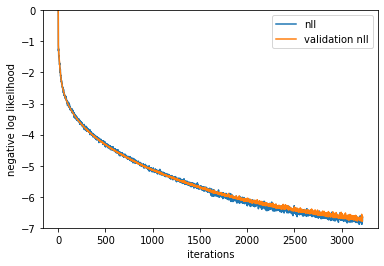

In [34]:
# lets do some plots
import matplotlib.pyplot as plt

# training progression plot
fig = plt.figure()
plt.plot(loss_log['nll'], label='nll')
plt.plot(loss_log['val_nll'], label='validation nll')
# plt.yscale("log")
plt.ylim([-7,0])
plt.xlabel("iterations")
plt.ylabel("negative log likelihood")
plt.legend()

plt.show()






In [35]:
# x, c = next(iter(test_loader))
# xt, ct = next(iter(train_loader))

# x_pred, _ = cinn(xt, c=ct)

# print(c.shape, ct.shape)
# torch.save(cinn.state_dict(), "/content/gdrive/MyDrive/code/cinn.pt")
# torch.save(cinn,  "/content/gdrive/MyDrive/code/cinn.model")

# torch.save(cinn.state_dict())
from voxelmorph.torch.layers import VecInt
from voxelmorph.torch.layers import SpatialTransformer

def apply_flow (volume, v_field, device=torch.device('cpu')):
    if type(volume) == np.ndarray:
        volume = torch.from_numpy(volume)
    if type(v_field) == np.ndarray:
        v_field = torch.from_numpy(v_field)

    # volume = volume.to(device)
    # v_field = v_field.to(device)
    shp = volume.shape[2:]
    print(shp)
    integrator = VecInt(inshape=v_field.shape[2:], nsteps=7).to(device)
    transformer = SpatialTransformer(size=shp).to(device)
    deformation = integrator(v_field)
    transformed = transformer(volume, deformation)
    return transformed, deformation

torch.Size([28, 28])
torch.Size([28, 28])


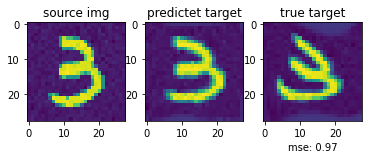

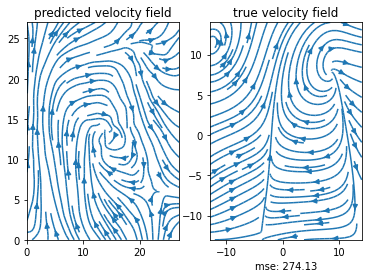

torch.Size([28, 28])
torch.Size([28, 28])


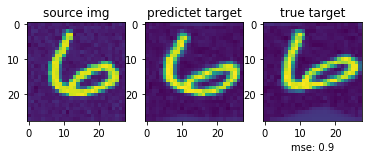

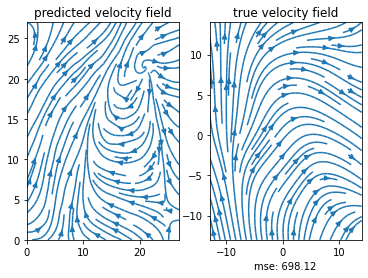

torch.Size([28, 28])
torch.Size([28, 28])


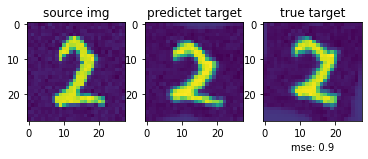

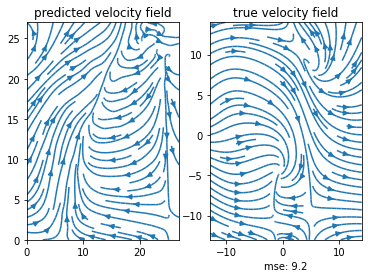

torch.Size([28, 28])
torch.Size([28, 28])


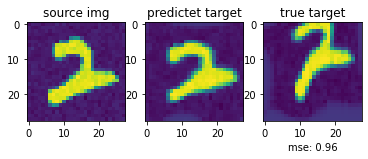

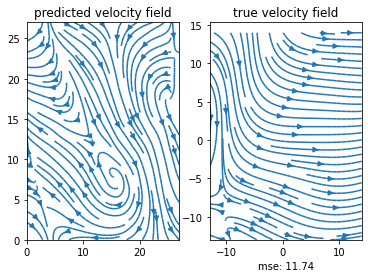

torch.Size([28, 28])
torch.Size([28, 28])


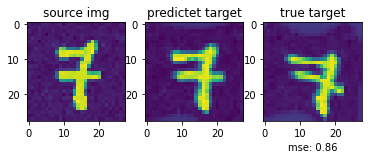

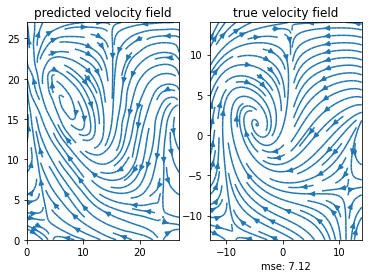

torch.Size([28, 28])
torch.Size([28, 28])


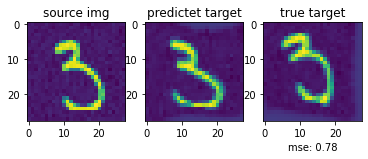

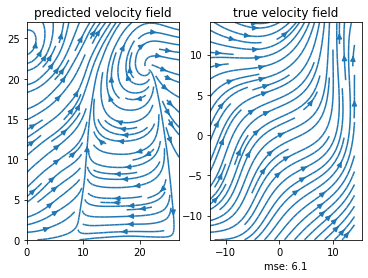

torch.Size([28, 28])
torch.Size([28, 28])


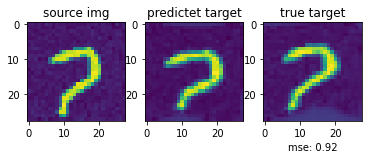

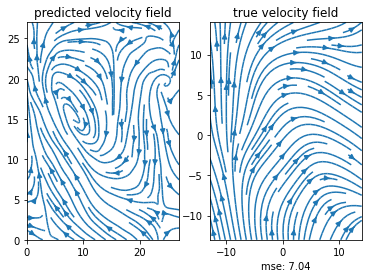

torch.Size([28, 28])
torch.Size([28, 28])


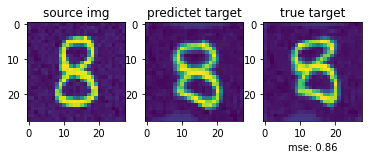

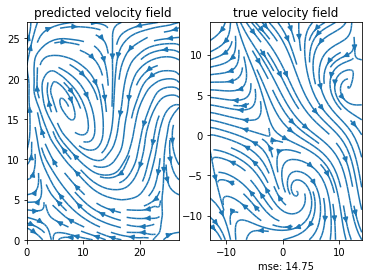

torch.Size([28, 28])
torch.Size([28, 28])


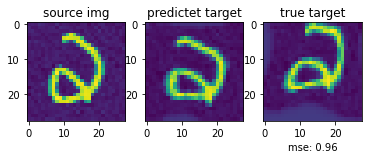

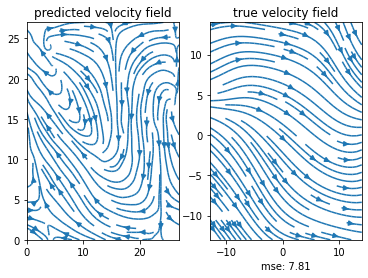

torch.Size([28, 28])
torch.Size([28, 28])


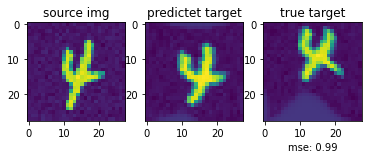

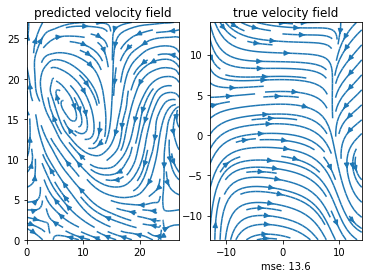

torch.Size([28, 28])
torch.Size([28, 28])


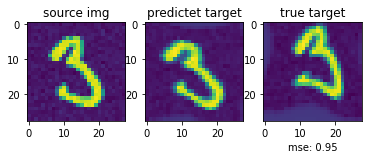

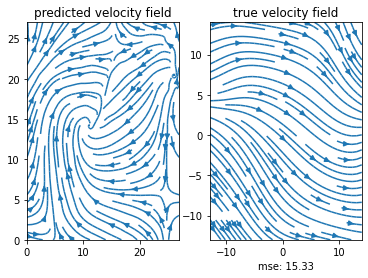

torch.Size([28, 28])
torch.Size([28, 28])


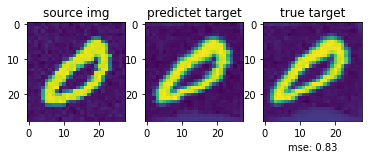

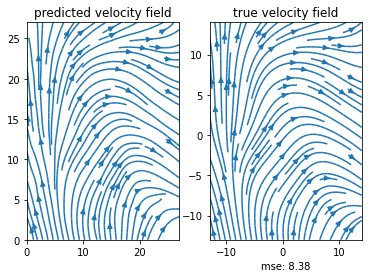

torch.Size([28, 28])
torch.Size([28, 28])


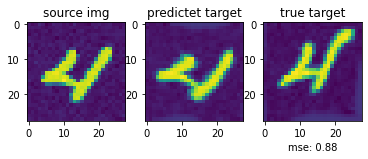

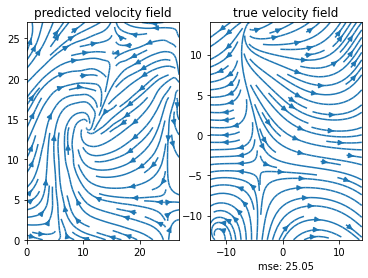

torch.Size([28, 28])
torch.Size([28, 28])


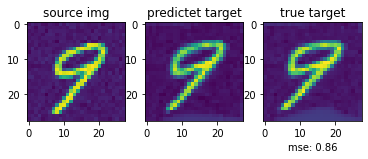

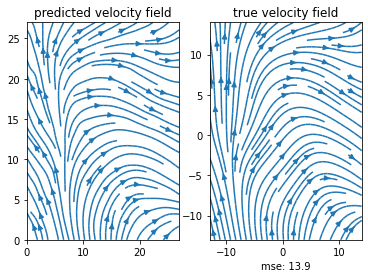

torch.Size([28, 28])
torch.Size([28, 28])


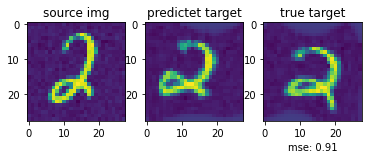

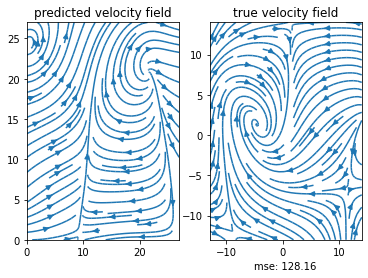

torch.Size([28, 28])
torch.Size([28, 28])


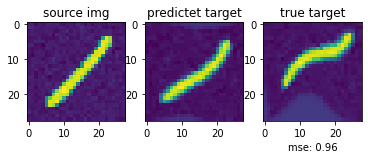

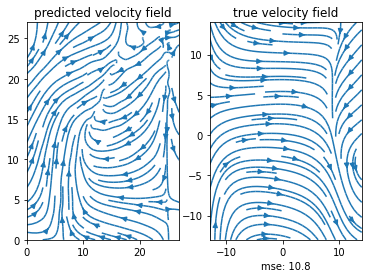

torch.Size([28, 28])
torch.Size([28, 28])


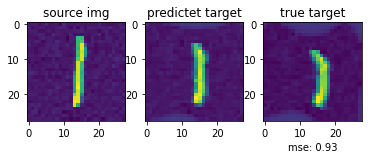

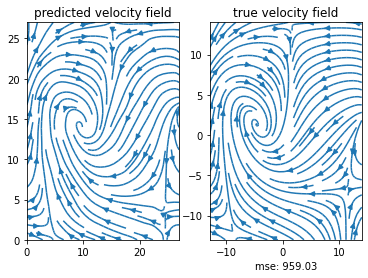

torch.Size([28, 28])
torch.Size([28, 28])


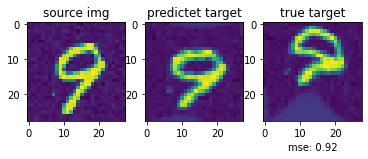

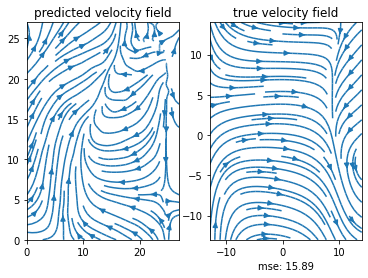

torch.Size([28, 28])
torch.Size([28, 28])


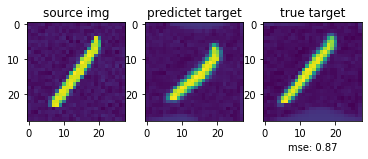

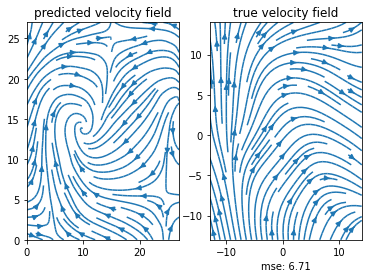

torch.Size([28, 28])
torch.Size([28, 28])


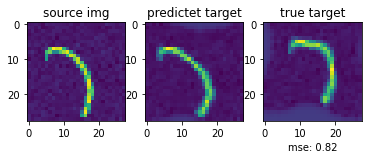

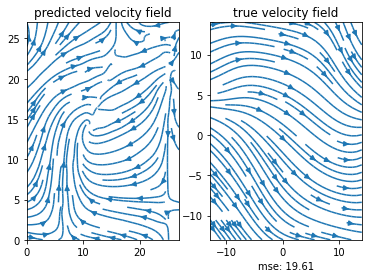

torch.Size([28, 28])
torch.Size([28, 28])


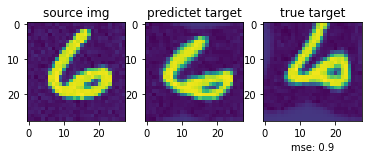

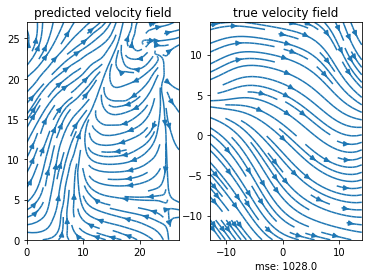

torch.Size([28, 28])
torch.Size([28, 28])


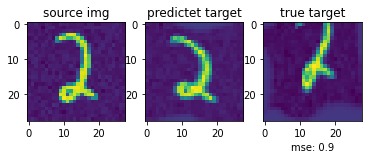

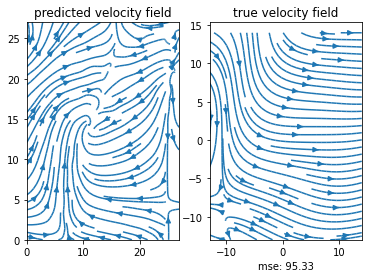

torch.Size([28, 28])
torch.Size([28, 28])


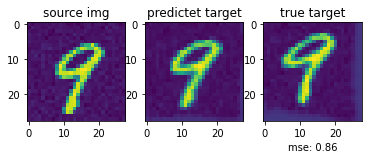

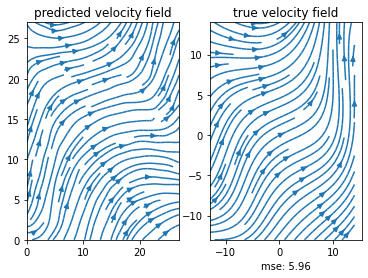

torch.Size([28, 28])
torch.Size([28, 28])


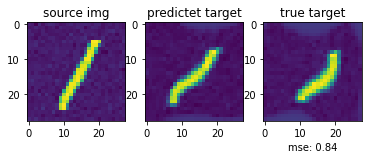

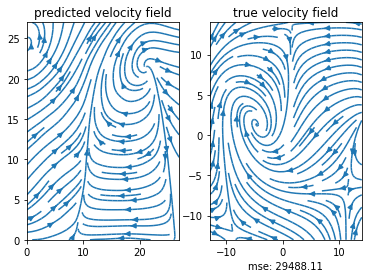

torch.Size([28, 28])
torch.Size([28, 28])


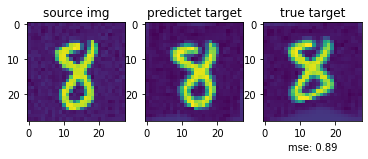

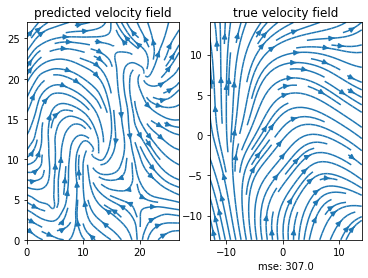

torch.Size([28, 28])
torch.Size([28, 28])


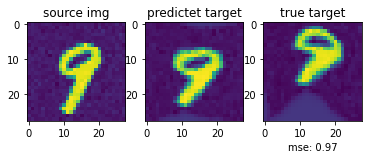

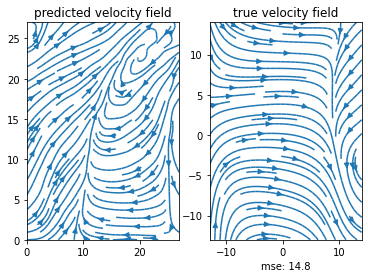

torch.Size([28, 28])
torch.Size([28, 28])


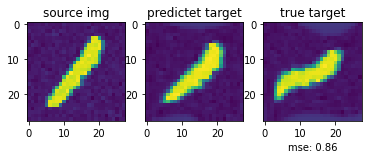

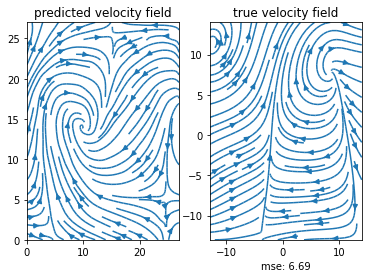

torch.Size([28, 28])
torch.Size([28, 28])


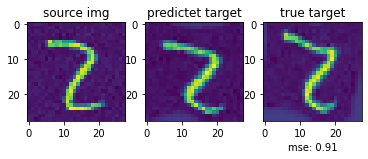

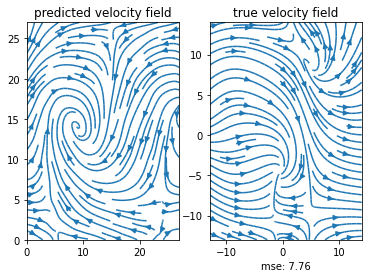

torch.Size([28, 28])
torch.Size([28, 28])


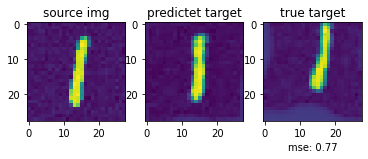

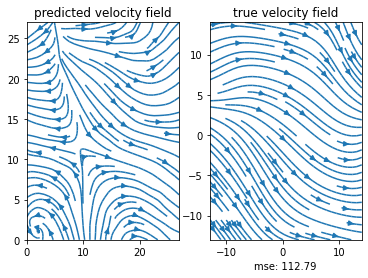

torch.Size([28, 28])
torch.Size([28, 28])


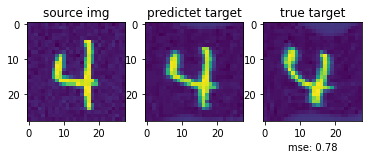

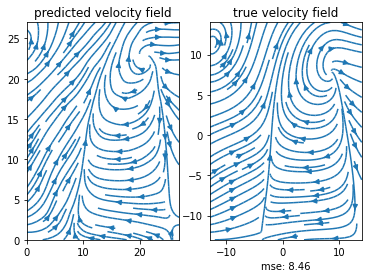

torch.Size([28, 28])
torch.Size([28, 28])


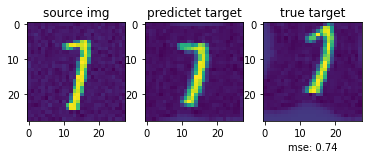

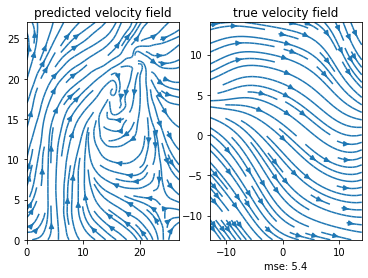

torch.Size([28, 28])
torch.Size([28, 28])


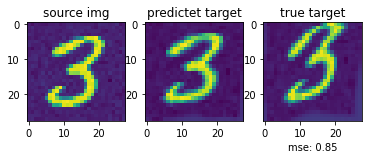

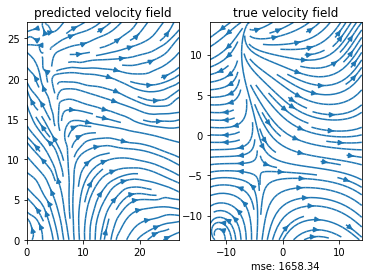

torch.Size([28, 28])
torch.Size([28, 28])


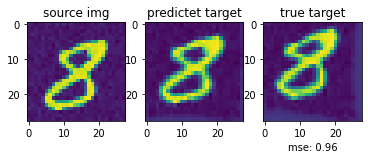

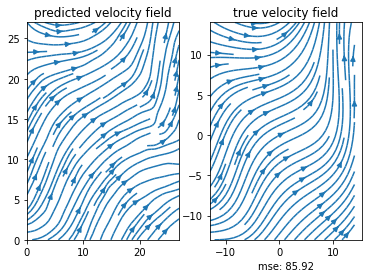

torch.Size([28, 28])


KeyboardInterrupt: ignored

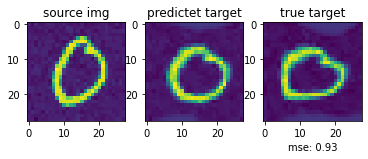

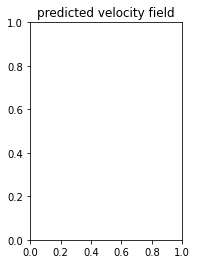

In [36]:
import matplotlib.pyplot as plt

mse = torch.nn.MSELoss()

plot = True



# z = torch.randn(batch_size, ndim_total)
# x_pred, _ = cinn(x, c=c, rev=False)  # predicted ve


cinn.eval()

next(cinn.parameters()).device
with torch.no_grad():

    field_err = []
    reconstruction_err = []
    
    for v_field, c in test_loader:

        v_field = v_field.to(device)
        # print(v_field.shape)
        c = c.to(device)
        # x = true field
        # c = condition vector of composed moving and fixed image (m,f)
        z = torch.randn(batch_size, 2*28*28).to(device)
        v_field_pred, _ = cinn(z, c=c, rev=True)  # predicted velocity field
        
        source_imgs = c[:, 0, ...]
        
        source = c[:, :1, ...].to(device)
        target = c[:, 1:, ...].to(device)
        
        target_pred, _ = apply_flow(v_field=v_field_pred, volume=source, device=device)

        
        field_err.append(mse(v_field, v_field_pred).item())
        reconstruction_err.append(mse(target, target_pred).item())

        if plot:
            source = source.to(torch.device("cpu"))
            target = target.to(torch.device("cpu"))
            target_pred = target_pred.to(torch.device("cpu"))
            v_field = v_field.to(torch.device("cpu"))
            v_field_pred = v_field_pred.to(torch.device("cpu"))

            # print(v_field.shape)
            # print(v_field_pred.shape)   
            
            fig = plt.figure()

            idx = np.random.randint(source.shape[1])


            ax1 = fig.add_subplot(1, 3, 1)
            ax1.set_title("source img")
            ax1.imshow(source[idx, 0, :, :])
            
            
            ax2 = fig.add_subplot(1, 3, 2)
            ax2.set_title("predictet target")
            ax2.imshow(target_pred[idx, 0, :, :])

            ax3 = fig.add_subplot(1, 3, 3)
            ax3.set_title("true target")
            ax3.imshow(target[idx, 0, :, :])
            ax3.set_xlabel("mse: {}".format(round(reconstruction_err[-1],2)))

            fig2 = plt.figure()

            ax4 = fig2.add_subplot(1, 2, 1)
            ax4.set_title("predicted velocity field")
            # ax4.imshow(v_field_pred[idx, 0, :, :])
            u,v = v_field_pred[idx, 0, :, :], v_field_pred[idx,1,:,:]
            x,y = np.meshgrid(np.linspace(0, 27,28),np.linspace(0,27,28))
            plt.streamplot(x,y, u,v)

            ax5 = fig2.add_subplot(1, 2, 2)
            ax5.set_title("true velocity field")
            # ax5.imshow(v_field[idx, 0, :, :])
            u,v = v_field[idx,0], v_field[idx,1]
            print(u.shape)
            x,y = np.meshgrid(np.linspace(-13, 14,28),np.linspace(-13,14,28))
            plt.streamplot(x,y, u,v)
            ax5.set_xlabel("mse: {}".format(round(field_err[-1], 2)))

            


            plt.show()

In [ ]:
def evalutate(cinn, test_loader, idx=None, plot=True):
    mse = torch.nn.MSELoss()

    cinn.eval()

    with torch.no_grad():

        field_err = []
        reconstruction_err = []
        
        for v_field, c in test_loader:

            v_field = v_field.to(device)
            c = c.to(device)
            # x = true field
            # c = condition vector of composed moving and fixed image (m,f)
            z = torch.randn(batch_size, ndim_total).to(device)
            v_field_pred, _ = cinn(z, c=c, rev=True)  # predicted velocity field
            
            source_imgs = c[:, 0, ...]
            
            source = c[:, :1, ...].to(device)
            target = c[:, 1:, ...].to(device)
            
            target_pred, _ = apply_flow(v_field=v_field_pred, volume=source, device=device)

            
            field_err.append(mse(v_field, v_field_pred).item())
            reconstruction_err.append(mse(target, target_pred).item())

            if plot:
                source = source.to(torch.device("cpu"))
                target = target.to(torch.device("cpu"))
                target_pred = target_pred.to(torch.device("cpu"))
                v_field = v_field.to(torch.device("cpu"))
                v_field_pred = v_field_pred.to(torch.device("cpu"))
                
                fig = plt.figure()

                idx = np.random.randint(source.shape[1])


                ax1 = fig.add_subplot(1, 3, 1)
                ax1.set_title("source img")
                ax1.imshow(source[idx, 0, :, :])
                
                
                ax2 = fig.add_subplot(1, 3, 2)
                ax2.set_title("predictet target")
                ax2.imshow(target_pred[idx, 0, :, :])

                ax3 = fig.add_subplot(1, 3, 3)
                ax3.set_title("true target")
                ax3.imshow(target[idx, 0, :, :])
                ax3.set_xlabel("mse: {}".format(round(reconstruction_err[-1],2)))

                fig2 = plt.figure()

                ax4 = fig2.add_subplot(1, 2, 1)
                ax4.set_title("predicted velocity field")
                # ax4.imshow(v_field_pred[idx, 0, :, :])
                u,v = v_field_pred[idx,0], v_field_pred[idx,1]
                x,y = np.meshgrid(np.linspace(-13, 14,28),np.linspace(-13,14,28))
                plt.streamplot(x,y, u,v)

                ax5 = fig2.add_subplot(1, 2, 2)
                ax5.set_title("true velocity field")
                # ax5.imshow(v_field[idx, 0, :, :])
                u,v = v_field[idx,0], v_field[idx,1]
                x,y = np.meshgrid(np.linspace(-13, 14,28),np.linspace(-13,14,28))
                plt.streamplot(x,y, u,v)
                ax5.set_xlabel("mse: {}".format(round(field_err[-1], 2)))

                


                plt.show()
    return field_error, reconstruction_error

In [ ]:
# batch_size = 10

# test_set = datasets.MNIST(root="./data", train=False, download=True, 
#                            transform=torchvision.transforms.ToTensor())
# test_loader = utils.data.DataLoader(test_set, shuffle=False, batch_size=batch_size)

In [ ]:
# cinn.eval()

# n_samples = 10
# n_dim_total = 784

# with torch.no_grad():

    # z = torch.randn(n_samples, n_dim_total).to(device)
    # print(z.shape)
    # labels = torch.LongTensor([1, 0, 2, 5, 3, 2, 8, 5, 7, 9]).to(device)
    # one_hot_l = torch.nn.functional.one_hot(labels, num_classes=10).to(device)
    # print(one_hot_labels.shape)
    # samples, _ = cinn(z, [one_hot_l], rev=True)

In [ ]:
# import matplotlib.pyplot as plt
# samples = samples.view(-1, 28, 28)

# fig = plt.figure(figsize=(20,20))
# for i, sample in enumerate(samples):
#     print(sample.shape)
#     sample = sample.cpu().detach().numpy()
#     ax = fig.add_subplot(n_samples / 2, n_samples / 2, i+1 )
#     plt.imshow(sample)
# plt.show()

NameError: ignored

> <ipython-input-28-2078570cfcbe>(2)<module>()
      1 import matplotlib.pyplot as plt
----> 2 samples = samples.view(-1, 28, 28)
      3 
      4 fig = plt.figure(figsize=(20,20))
      5 for i, sample in enumerate(samples):

--KeyboardInterrupt--
--KeyboardInterrupt--
--KeyboardInterrupt--
ipdb> q
ipdb> q
ipdb> q


In [ ]:
def evaluate_model(cinn, x_true, cond, ndim_total, device):
    cinn.eval()
    z = torch.randn((x_true.shape[0], ndim_total)).to(device)
    x_pred, _ = cinn(z, c=cond, rev=True)

    fixed = cond[:, 0, :, :]
    moving = cond[:, 1, :, :]

    moving_pred = apply_flow(fixed, x_pred)

    rec_error = torch.mean(torch.abs(moving - moving_pred))

    return rec_error

In [ ]:

for v_x, v_c in test_loader:
    v_x = v_x.to(device)
    v_c = v_c.to(device)
    err = evaluate_model(cinn, v_x, v_c, 784, device)
    print(err)

NameError: ignored

In [ ]:
def rec_error(flow_field, source, target):
    pred = apply_flow(flow_field, source)
    loss = 